In [ ]:
!pip install numpy pandas timezonefinder retry-requests requests-cache openmeteo-requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 45.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
from pytz import timezone
from datetime import datetime
from retry_requests import retry
from openmeteo_requests import Client
from requests_cache import CachedSession
from timezonefinder import TimezoneFinder
from sklearn.ensemble import RandomForestClassifier
from pandas import date_range, to_datetime, DataFrame, Timedelta

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error (done once)
cache_session = CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = Client(session=retry_session)

In [ ]:
def get_current_time(latitude, longitude):
    # Find the time zone based on latitude and longitude
    tf = TimezoneFinder()
    timezone_str = tf.timezone_at(lat=latitude, lng=longitude)

    if timezone_str is None:
        raise ValueError("Could not determine the timezone for the given location.")

    # Get the current time in the specified time zone
    tz = timezone(timezone_str)
    current_time = datetime.now(timezone)

    return current_time, tz

In [ ]:
def calculate_past_days(latitude, longitude, target_datetime):
    # Get the current datetime and timezone based on latitude and longitude
    current_datetime, timezone = get_current_time(latitude, longitude)  # No need to pass latitude, longitude here

    # Make a copy of target_datetime and localize it to the timezone
    localized_target_datetime = timezone.localize(target_datetime)

    # Zero out minutes and seconds to consider only the hour
    current_datetime = current_datetime.replace(minute=0, second=0, microsecond=0)
    localized_target_datetime = localized_target_datetime.replace(minute=0, second=0, microsecond=0)

    # Calculate the time difference in hours
    time_difference = current_datetime - localized_target_datetime
    total_hours = time_difference.total_seconds() // 3600  # Total hours

    # Convert total hours to full past days
    past_days = int(total_hours // 24)

    # Add 1 for exclusivity if there are leftover hours or if they are exactly aligned
    if total_hours % 24 > 0 or total_hours == past_days * 24:
        past_days += 1

    return past_days

In [ ]:
import pandas as pd
def fetch_weather_data(latitude, longitude, target_datetime):
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": "temperature_2m",
        "temperature_unit": "fahrenheit",
        "timezone": "auto",
        "past_days": calculate_past_days(latitude, longitude, target_datetime),
        "forecast_days": 1
    }

    # Get the weather data from the API (example: using openmeteo API)
    responses = openmeteo.weather_api(url, params=params)

    # Process first location (since only one response is expected for now)
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Process hourly data
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_time = pd.to_datetime(hourly.Time(), unit="s", utc=True)

    # Create a DataFrame with hourly data
    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        ),
        "temperature_2m": hourly_temperature_2m
    }

    hourly_dataframe = pd.DataFrame(data=hourly_data)

    # Find the temperature for the target_datetime
    target_datetime_utc = pd.to_datetime(target_datetime, utc=True)

    # Find the row where the date is closest to the target_datetime
    target_row = hourly_dataframe.loc[
        hourly_dataframe["date"] == target_datetime_utc
    ]

    if not target_row.empty:
        return target_row["temperature_2m"].values[0]
    else:
        print("Target datetime not found in the data.")
        return None

def fetch_air_quality_data(latitude, longitude, target_datetime):
    url = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": ["pm10", "carbon_dioxide", "nitrogen_dioxide", "dust"],
        "timezone": "auto",
        "past_days": calculate_past_days(latitude, longitude, target_datetime),
        "forecast_days": 1
    }

    # Get the air quality data from the API (example: using openmeteo API)
    responses = openmeteo.weather_api(url, params=params)

    # Process first location (since only one response is expected for now)
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Process hourly data
    hourly = response.Hourly()
    hourly_pm10 = hourly.Variables(0).ValuesAsNumpy()
    hourly_carbon_dioxide = hourly.Variables(1).ValuesAsNumpy()
    hourly_nitrogen_dioxide = hourly.Variables(2).ValuesAsNumpy()
    hourly_dust = hourly.Variables(3).ValuesAsNumpy()
    hourly_time = pd.to_datetime(hourly.Time(), unit="s", utc=True)

    # Create a DataFrame with hourly data
    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        ),
        "pm10": hourly_pm10,
        "carbon_dioxide": hourly_carbon_dioxide,
        "nitrogen_dioxide": hourly_nitrogen_dioxide,
        "dust": hourly_dust
    }

    hourly_dataframe = pd.DataFrame(data=hourly_data)

    # Convert target_datetime to UTC
    target_datetime_utc = pd.to_datetime(target_datetime, utc=True)

    # Find the row where the date is exactly equal to target_datetime_utc
    target_row = hourly_dataframe.loc[
        hourly_dataframe["date"] == target_datetime_utc
    ]

    if not target_row.empty:
        # If an exact match is found, extract the values for air quality parameters
        current_values = {
            "pm10": target_row["pm10"].values[0],
            "carbon_dioxide": target_row["carbon_dioxide"].values[0],
            "nitrogen_dioxide": target_row["nitrogen_dioxide"].values[0],
            "dust": target_row["dust"].values[0]
        }
    else:
        print("Target datetime not found in the data.")
        return None

    return current_values





In [ ]:
# prompt: write some mock data for the variables

latitude = 37.7749  # San Francisco
longitude = -122.4194 # San Francisco
target_datetime = datetime(2023, 10, 26, 10, 0, 0)  # Example target datetime


In [ ]:
# Get the temperature for the target datetime
temperature_at_target = fetch_weather_data(latitude, longitude, target_datetime)
print(f"Temperature at {target_datetime}: {temperature_at_target}°F")

# Get the air quality for the target datetime
air_quality_at_target = fetch_air_quality_data(latitude, longitude, target_datetime)
print(f"Air quality at {target_datetime}: {air_quality_at_target}")

TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'function'

In [ ]:
# Example of how the training data might look
# Each row: [temperature, pm10, co2, no2, dust, asthma_attack (0/1)]
data = pd.DataFrame({
    'temperature': [65, 70, 75, 80, 85],
    'pm10': [5, 15, 10, 20, 30],
    'carbon_dioxide': [400, 450, 420, 430, 460],
    'nitrogen_dioxide': [10, 15, 12, 18, 20],
    'dust': [0, 1, 0, 2, 0],
    'asthma_attack': [0, 1, 0, 1, 0]  # 1 indicates an asthma attack
})

# Features and target
X = data[['temperature', 'pm10', 'carbon_dioxide', 'nitrogen_dioxide', 'dust']]
y = data['asthma_attack']

# Train a random forest classifier (or use another model)
model = RandomForestClassifier()
model.fit(X, y)

# Example prediction for new data (with new values of the 5 parameters)
new_data = pd.DataFrame([[75, 10, 420, 12, 0]], columns=['temperature', 'pm10', 'carbon_dioxide', 'nitrogen_dioxide', 'dust'])
prediction = model.predict(new_data)

# Output the prediction: 1 for asthma attack, 0 for no attack
print(f"Prediction: {'Asthma Attack' if prediction[0] == 1 else 'No Attack'}")

Prediction: No Attack


In [ ]:
# prompt: write code to fit the model with 30 entries

# ... (Your existing code) ...

# Example of how the training data might look
# Each row: [temperature, pm10, co2, no2, dust, asthma_attack (0/1)]
data = pd.DataFrame({
    'temperature': [65, 70, 75, 80, 85, 72, 68, 78, 82, 88, 71, 69, 76, 79, 84, 73, 67, 77, 81, 87, 70, 66, 74, 83, 89, 74, 65, 73, 80, 86],
    'pm10': [5, 15, 10, 20, 30, 12, 8, 18, 22, 35, 11, 9, 16, 21, 32, 13, 7, 17, 23, 34, 14, 6, 13, 25, 36, 15, 5, 12, 21, 31],
    'carbon_dioxide': [400, 450, 420, 430, 460, 410, 390, 440, 445, 470, 405, 385, 430, 435, 465, 415, 380, 425, 440, 475, 400, 395, 420, 450, 480, 415, 390, 410, 435, 470],
    'nitrogen_dioxide': [10, 15, 12, 18, 20, 13, 9, 16, 19, 22, 11, 8, 14, 17, 21, 12, 7, 15, 18, 23, 14, 6, 11, 19, 24, 16, 9, 11, 17, 22],
    'dust': [0, 1, 0, 2, 0, 1, 0, 1, 2, 0, 0, 0, 1, 2, 0, 1, 0, 1, 2, 0, 1, 0, 0, 2, 0, 1, 0, 1, 2, 0],
    'asthma_attack': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]  # 1 indicates an asthma attack
})


# Features and target
X = data[['temperature', 'pm10', 'carbon_dioxide', 'nitrogen_dioxide', 'dust']]
y = data['asthma_attack']

# Train a random forest classifier (or use another model)
model = RandomForestClassifier()
model.fit(X, y)

new_data = {
    'temperature': 75,
    'pm10': 10,
    'carbon_dioxide': 420,
    'nitrogen_dioxide': 12,
    'dust': 0
}

df = pd.DataFrame([new_data])
prediction = model.predict(df)
print(f"Prediction: {'Asthma Attack' if prediction[0] == 1 else 'No Attack'}")

# # Example prediction for new data (with new values of the 5 parameters)
# new_data = pd.DataFrame([[75, 10, 420, 12, 0]], columns=['temperature', 'pm10', 'carbon_dioxide', 'nitrogen_dioxide', 'dust'])
# prediction = model.predict(new_data)

# # Output the prediction: 1 for asthma attack, 0 for no attack
# print(f"Prediction: {'Asthma Attack' if prediction[0] == 1 else 'No Attack'}")

Prediction: No Attack


In [ ]:
import requests
from datetime import datetime
from typing import Dict, Optional, List, Union
import logging

class OpenMeteoClient:
    def __init__(self):
        self.weather_base_url = "https://api.open-meteo.com/v1/forecast"
        self.air_quality_base_url = "https://air-quality-api.open-meteo.com/v1/air-quality"
        self.historical_weather_url = "https://archive-api.open-meteo.com/v1/archive"
        self.logger = logging.getLogger(__name__)

    def get_weather_and_air_quality(
        self,
        latitude: float,
        longitude: float,
        ) -> Dict[str, Union[float, None]]:
        """
        Fetch both weather and air quality data for a specific location.

        Args:
            latitude: Location latitude
            longitude: Location longitude

        Returns:
            Dictionary containing temperature and air quality metrics
        """
        try:
            # Get temperature from weather API
            weather_params = {
                "latitude": latitude,
                "longitude": longitude,
                "current": "temperature_2m",
            }
            weather_response = requests.get(self.weather_base_url, params=weather_params)
            weather_response.raise_for_status()
            weather_data = weather_response.json()

            # Get air quality metrics
            air_params = {
                "latitude": latitude,
                "longitude": longitude,
                "current": ["pm10", "carbon_monoxide", "nitrogen_dioxide", "dust"],
            }
            air_response = requests.get(self.air_quality_base_url, params=air_params)
            air_response.raise_for_status()
            air_data = air_response.json()

            # Combine the data
            return {
                "temperature": weather_data.get("current", {}).get("temperature_2m"),
                "pm10": air_data.get("current", {}).get("pm10"),
                "carbon_dioxide": air_data.get("current", {}).get("carbon_monoxide"),
                "nitrogen_dioxide": air_data.get("current", {}).get("nitrogen_dioxide"),
                "dust": air_data.get("current", {}).get("dust")
            }

        except requests.exceptions.RequestException as e:
            self.logger.error(f"Error fetching data: {str(e)}")
            return {
                "temperature": None,
                "pm10": None,
                "carbon_dioxide": None,
                "nitrogen_dioxide": None,
                "dust": None
            }

    def get_historical_data(
        self,
        latitude: float,
        longitude: float,
        start_date: str,
        end_date: str
        ) -> Dict[str, List[float]]:
        """
        Fetch historical weather and air quality data for a date range.

        Args:
            latitude: Location latitude
            longitude: Location longitude
            start_date: Start date in ISO format (YYYY-MM-DD)
            end_date: End date in ISO format (YYYY-MM-DD)

        Returns:
            Dictionary containing lists of historical values for each metric
        """
        try:
            # Get historical weather data using archive API
            weather_params = {
                "latitude": latitude,
                "longitude": longitude,
                "start_date": start_date,
                "end_date": end_date,
                "daily": "temperature_2m_max",
                "timezone": "GMT"
            }
            weather_response = requests.get(self.historical_weather_url, params=weather_params)
            weather_response.raise_for_status()
            weather_data = weather_response.json()

            # Get historical air quality data
            air_params = {
                "latitude": latitude,
                "longitude": longitude,
                "start_date": start_date,
                "end_date": end_date,
                "hourly": ["pm10", "carbon_monoxide", "nitrogen_dioxide", "dust"]
            }
            air_response = requests.get(self.air_quality_base_url, params=air_params)
            air_response.raise_for_status()
            air_data = air_response.json()

            # Process hourly air quality data to daily averages
            hourly_data = air_data.get("hourly", {})
            days = len(weather_data.get("daily", {}).get("temperature_2m_max", []))

            # Initialize lists for air quality metrics
            pm10_daily = []
            co2_daily = []
            no2_daily = []
            dust_daily = []

            # Calculate daily averages from hourly data (24 hours per day)
            for day in range(days):
                start_idx = day * 24
                end_idx = start_idx + 24

                # Calculate averages for each metric, handling None values
                pm10_vals = [x for x in hourly_data.get("pm10", [])[start_idx:end_idx] if x is not None]
                co2_vals = [x for x in hourly_data.get("carbon_monoxide", [])[start_idx:end_idx] if x is not None]
                no2_vals = [x for x in hourly_data.get("nitrogen_dioxide", [])[start_idx:end_idx] if x is not None]
                dust_vals = [x for x in hourly_data.get("dust", [])[start_idx:end_idx] if x is not None]

                pm10_daily.append(sum(pm10_vals) / len(pm10_vals) if pm10_vals else None)
                co2_daily.append(sum(co2_vals) / len(co2_vals) if co2_vals else None)
                no2_daily.append(sum(no2_vals) / len(no2_vals) if no2_vals else None)
                dust_daily.append(sum(dust_vals) / len(dust_vals) if dust_vals else None)

            return {
                "temperature": weather_data.get("daily", {}).get("temperature_2m_max", []),
                "pm10": pm10_daily,
                "carbon_dioxide": co2_daily,
                "nitrogen_dioxide": no2_daily,
                "dust": dust_daily
            }

        except requests.exceptions.RequestException as e:
            self.logger.error(f"Error fetching historical data: {str(e)}")
            return {
                "temperature": [],
                "pm10": [],
                "carbon_dioxide": [],
                "nitrogen_dioxide": [],
                "dust": []
            }

In [ ]:
# Initialize the client
client = OpenMeteoClient()

# Get current data
current_data = client.get_weather_and_air_quality(
    latitude=40.833091,
    longitude=-73.925254
)

# Get historical data
historical_data = client.get_historical_data(
    latitude=51.5074,
    longitude=-0.1278,
    start_date="2024-01-01",
    end_date="2024-01-31"
)

In [ ]:
current_data

{'temperature': 6.0,
 'pm10': 5.1,
 'carbon_dioxide': 163.0,
 'nitrogen_dioxide': 5.6,
 'dust': 0.0}

In [ ]:
historical_data

{'temperature': [11.0,
  12.9,
  10.4,
  8.3,
  7.1,
  6.4,
  4.8,
  3.4,
  4.1,
  4.8,
  5.6,
  6.9,
  4.3,
  5.8,
  2.5,
  3.9,
  2.5,
  2.6,
  4.8,
  5.2,
  11.8,
  12.5,
  13.0,
  12.3,
  11.9,
  12.1,
  8.5,
  10.8,
  12.9,
  12.1,
  11.0],
 'pm10': [8.579166666666666,
  6.500000000000001,
  7.675,
  11.658333333333337,
  14.954166666666667,
  17.570833333333336,
  7.612500000000001,
  7.0249999999999995,
  11.691666666666668,
  11.616666666666665,
  16.270833333333332,
  15.575000000000001,
  20.82083333333333,
  16.07083333333333,
  13.625,
  24.070833333333336,
  26.65833333333333,
  19.454166666666666,
  21.29583333333333,
  12.85,
  9.766666666666667,
  11.325000000000001,
  11.858333333333334,
  13.125,
  16.641666666666662,
  13.354166666666666,
  19.27916666666666,
  14.345833333333331,
  25.325,
  16.441666666666663,
  21.82916666666667],
 'carbon_dioxide': [173.625,
  147.45833333333334,
  175.04166666666666,
  199.125,
  207.33333333333334,
  238.125,
  179.875,
  183.9

In [ ]:
from datetime import datetime
import pytz
from timezonefinder import TimezoneFinder
import pandas as pd

latitude = 40.7128
longitude = -74.0060
target_datetime = datetime(2024, 11, 6, 8)

def get_current_time(latitude, longitude):
    # Find the time zone based on latitude and longitude
    tf = TimezoneFinder()
    timezone_str = tf.timezone_at(lat=latitude, lng=longitude)

    if timezone_str is None:
        raise ValueError("Could not determine the timezone for the given location.")

    # Get the current time in the specified time zone
    timezone = pytz.timezone(timezone_str)
    current_time = datetime.now(timezone)

    return current_time, timezone

def calculate_past_days(latitude, longitude, target_datetime):
    # Get the current datetime and timezone based on latitude and longitude
    current_datetime, timezone = get_current_time(latitude, longitude)  # No need to pass latitude, longitude here

    # Make a copy of target_datetime and localize it to the timezone
    localized_target_datetime = timezone.localize(target_datetime)

    # Zero out minutes and seconds to consider only the hour
    current_datetime = current_datetime.replace(minute=0, second=0, microsecond=0)
    localized_target_datetime = localized_target_datetime.replace(minute=0, second=0, microsecond=0)

    # Calculate the time difference in hours
    time_difference = current_datetime - localized_target_datetime
    total_hours = time_difference.total_seconds() // 3600  # Total hours

    # Convert total hours to full past days
    past_days = int(total_hours // 24)

    # Add 1 for exclusivity if there are leftover hours or if they are exactly aligned
    if total_hours % 24 > 0 or total_hours == past_days * 24:
        past_days += 1

    return past_days

def fetch_weather_data(latitude, longitude, target_datetime):
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": "temperature_2m",
        "temperature_unit": "fahrenheit",
        "timezone": "auto",
        "past_days": calculate_past_days(latitude, longitude, target_datetime),
        "forecast_days": 1
    }

    # Get the weather data from the API (example: using openmeteo API)
    responses = openmeteo.weather_api(url, params=params)

    # Process first location (since only one response is expected for now)
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Process hourly data
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_time = pd.to_datetime(hourly.Time(), unit="s", utc=True)

    # Create a DataFrame with hourly data
    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        ),
        "temperature_2m": hourly_temperature_2m
    }

    hourly_dataframe = pd.DataFrame(data=hourly_data)

    # Find the temperature for the target_datetime
    target_datetime_utc = pd.to_datetime(target_datetime, utc=True)

    # Find the row where the date is closest to the target_datetime
    target_row = hourly_dataframe.loc[
        hourly_dataframe["date"] == target_datetime_utc
    ]

    if not target_row.empty:
        return target_row["temperature_2m"].values[0]
    else:
        print("Target datetime not found in the data.")
        return None

def fetch_air_quality_data(latitude, longitude, target_datetime):
    url = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": ["pm10", "carbon_dioxide", "nitrogen_dioxide", "dust"],
        "timezone": "auto",
        "past_days": calculate_past_days(latitude, longitude, target_datetime),
        "forecast_days": 1
    }

    # Get the air quality data from the API (example: using openmeteo API)
    responses = openmeteo.weather_api(url, params=params)

    # Process first location (since only one response is expected for now)
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

    # Process hourly data
    hourly = response.Hourly()
    hourly_pm10 = hourly.Variables(0).ValuesAsNumpy()
    hourly_carbon_dioxide = hourly.Variables(1).ValuesAsNumpy()
    hourly_nitrogen_dioxide = hourly.Variables(2).ValuesAsNumpy()
    hourly_dust = hourly.Variables(3).ValuesAsNumpy()
    hourly_time = pd.to_datetime(hourly.Time(), unit="s", utc=True)

    # Create a DataFrame with hourly data
    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        ),
        "pm10": hourly_pm10,
        "carbon_dioxide": hourly_carbon_dioxide,
        "nitrogen_dioxide": hourly_nitrogen_dioxide,
        "dust": hourly_dust
    }

    hourly_dataframe = pd.DataFrame(data=hourly_data)

    # Convert target_datetime to UTC
    target_datetime_utc = pd.to_datetime(target_datetime, utc=True)

    # Find the row where the date is exactly equal to target_datetime_utc
    target_row = hourly_dataframe.loc[
        hourly_dataframe["date"] == target_datetime_utc
    ]

    if not target_row.empty:
        # If an exact match is found, extract the values for air quality parameters
        current_values = {
            "pm10": target_row["pm10"].values[0],
            "carbon_dioxide": target_row["carbon_dioxide"].values[0],
            "nitrogen_dioxide": target_row["nitrogen_dioxide"].values[0],
            "dust": target_row["dust"].values[0]
        }
    else:
        print("Target datetime not found in the data.")
        return None

    return current_values

# Get the temperature for the target datetime
temperature_at_target = fetch_weather_data(latitude, longitude, target_datetime)
print(f"Temperature at {target_datetime}: {temperature_at_target}°F")

# Get the air quality for the target datetime
air_quality_at_target = fetch_air_quality_data(latitude, longitude, target_datetime)
print(f"Air quality at {target_datetime}: {air_quality_at_target}")


Coordinates 40.71033477783203°N -73.99308776855469°E
Elevation 32.0 m asl
Timezone b'America/New_York' b'EST'
Timezone difference to GMT+0 -18000 s
Temperature at 2024-11-06 08:00:00: 65.53579711914062°F
Coordinates 40.69999694824219°N -74.0°E
Elevation 32.0 m asl
Timezone b'America/New_York' b'EST'
Timezone difference to GMT+0 -18000 s
Air quality at 2024-11-06 08:00:00: {'pm10': 6.3, 'carbon_dioxide': 447.0, 'nitrogen_dioxide': 10.7, 'dust': 0.0}


In [11]:
import numpy as np
import pandas as pd

# Example of how the training data might look
# Each row: [temperature, pm10, co2, no2, dust, asthma_attack (0/1)]
data = pd.DataFrame({
    'temperature': [65, 70, 75, 80, 85],
    'pm10': [5, 15, 10, 20, 30],
    'carbon_dioxide': [400, 450, 420, 430, 460],
    'nitrogen_dioxide': [10, 15, 12, 18, 20],
    'dust': [0, 1, 0, 2, 0],
    'asthma_attack': [0, 1, 0, 1, 0]  # 1 indicates an asthma attack
})

# Features and target
X = data[['temperature', 'pm10', 'carbon_dioxide', 'nitrogen_dioxide', 'dust']]
y = data['asthma_attack']

# Train a random forest classifier (or use another model)
model = RandomForestClassifier()
model.fit(X, y)

# Example prediction for new data (with new values of the 5 parameters)
new_data = np.array([[75, 10, 420, 12, 0]])  # new input values
prediction = model.predict(new_data)

# Output the prediction: 1 for asthma attack, 0 for no attack
print(f"Prediction: {'Asthma Attack' if prediction[0] == 1 else 'No Attack'}")


Prediction: No Attack


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [22]:
# prompt: write code to fit the model with 30 entries

# ... (Your existing code) ...

# Example of how the training data might look
# Each row: [temperature, pm10, co2, no2, dust, asthma_attack (0/1)]
data = pd.DataFrame({
    'temperature': [65, 70, 75, 80, 85, 72, 68, 78, 82, 88, 71, 69, 76, 79, 84, 73, 67, 77, 81, 87, 70, 66, 74, 83, 89, 74, 65, 73, 80, 86],
    'pm10': [5, 15, 10, 20, 30, 12, 8, 18, 22, 35, 11, 9, 16, 21, 32, 13, 7, 17, 23, 34, 14, 6, 13, 25, 36, 15, 5, 12, 21, 31],
    'carbon_dioxide': [400, 450, 420, 430, 460, 410, 390, 440, 445, 470, 405, 385, 430, 435, 465, 415, 380, 425, 440, 475, 400, 395, 420, 450, 480, 415, 390, 410, 435, 470],
    'nitrogen_dioxide': [10, 15, 12, 18, 20, 13, 9, 16, 19, 22, 11, 8, 14, 17, 21, 12, 7, 15, 18, 23, 14, 6, 11, 19, 24, 16, 9, 11, 17, 22],
    'dust': [0, 1, 0, 2, 0, 1, 0, 1, 2, 0, 0, 0, 1, 2, 0, 1, 0, 1, 2, 0, 1, 0, 0, 2, 0, 1, 0, 1, 2, 0],
    'asthma_attack': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]  # 1 indicates an asthma attack
})


# Features and target
X = data[['temperature', 'pm10', 'carbon_dioxide', 'nitrogen_dioxide', 'dust']]
y = data['asthma_attack']

# Train a random forest classifier (or use another model)
model = RandomForestClassifier()
model.fit(X, y)

new_data = {
    'temperature': 75,
    'pm10': 10,
    'carbon_dioxide': 420,
    'nitrogen_dioxide': 12,
    'dust': 0
}

df = pd.DataFrame([new_data])
prediction = model.predict(df)
print(f"Prediction: {'Asthma Attack' if prediction[0] == 1 else 'No Attack'}")

# # Example prediction for new data (with new values of the 5 parameters)
# new_data = pd.DataFrame([[75, 10, 420, 12, 0]], columns=['temperature', 'pm10', 'carbon_dioxide', 'nitrogen_dioxide', 'dust'])
# prediction = model.predict(new_data)

# # Output the prediction: 1 for asthma attack, 0 for no attack
# print(f"Prediction: {'Asthma Attack' if prediction[0] == 1 else 'No Attack'}")

Prediction: No Attack


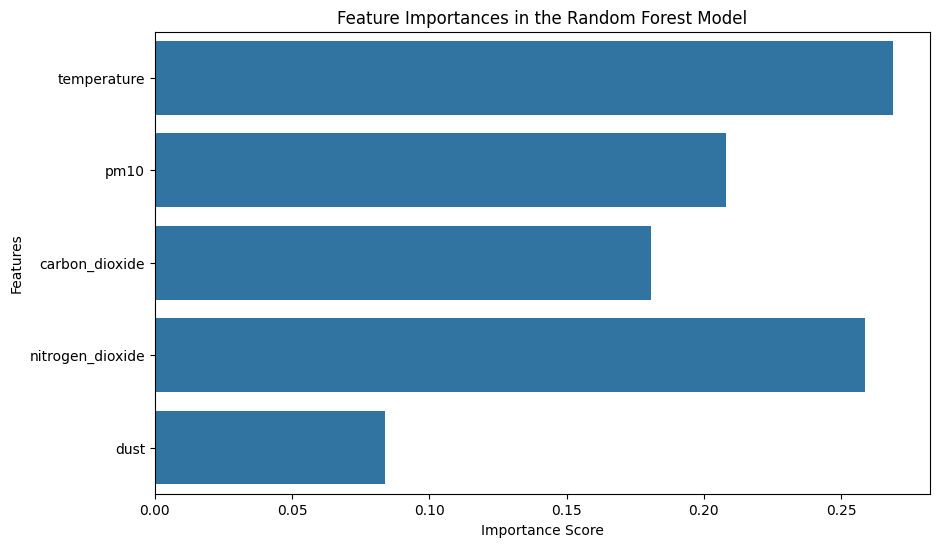

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names)
plt.title('Feature Importances in the Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()



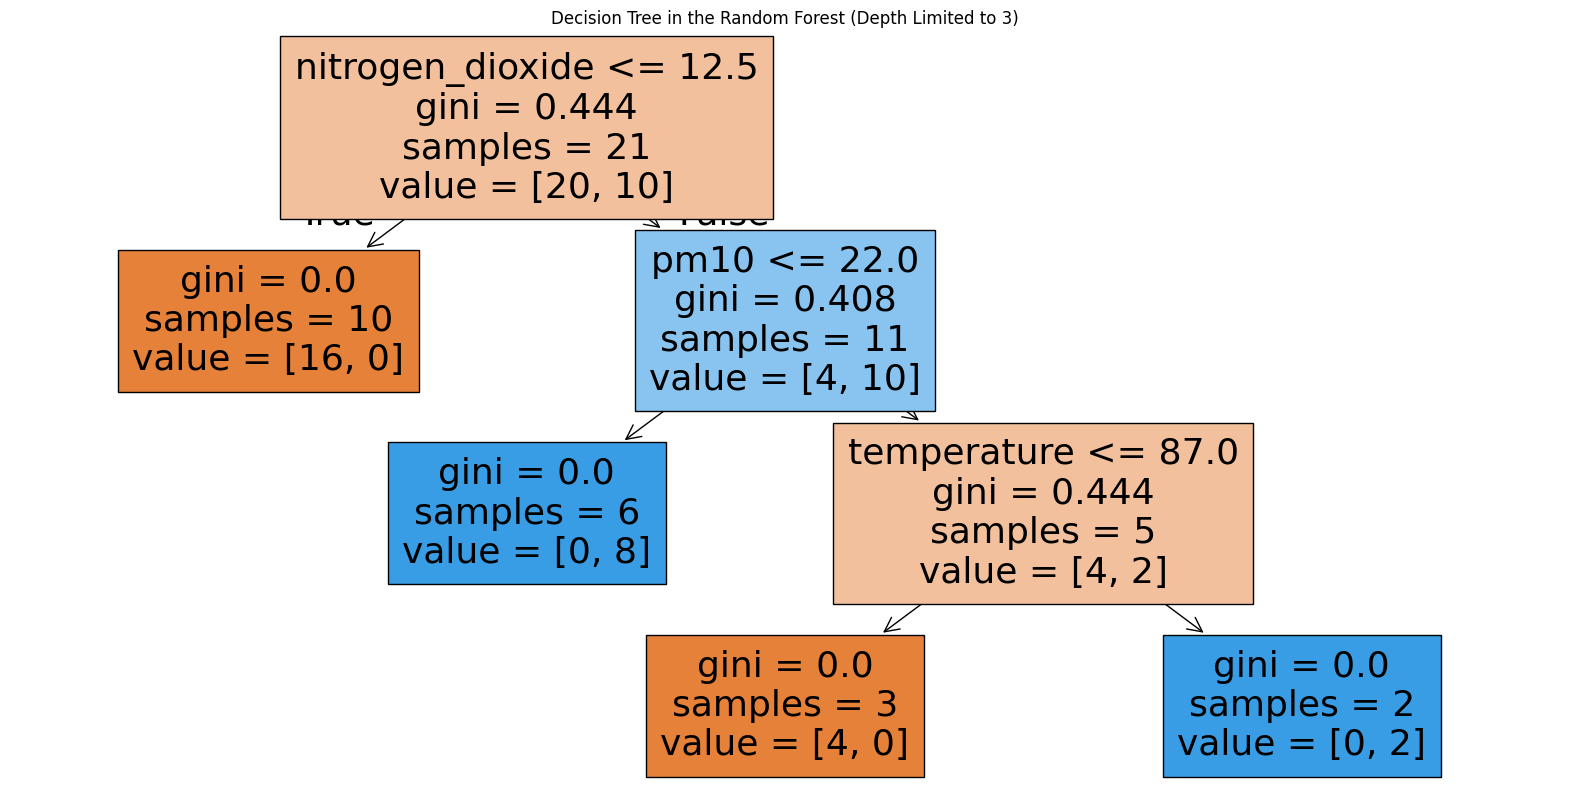

In [24]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], feature_names=feature_names, filled=True, max_depth=3)
plt.title('Decision Tree in the Random Forest (Depth Limited to 3)')
plt.show()
